In [3]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 7)
init_notebook_mode(connected=True)
colors = {
    'ndk': '#008894',
    'jvm': '#556DFF',
    
    'ndk_float': '#00C677',
    'ndk_short': '#008894',
    'jvm_float': '#CB43E1',
    'jvm_short': '#556DFF',

    'ndk_complex': '#00C677',
    'ndk_real': '#008894',
    'jvm_complex': '#CB43E1',
    'jvm_real': '#556DFF',

}
sns.set_palette(sns.color_palette(colors.values()))

convolution = pd.read_csv('data/convolution_benchmark_1566902061275.csv', index_col='env')
fft = pd.read_csv('data/fft_benchmark_1566902061275.csv', index_col='env')
conversion = pd.read_csv('data/conversion_benchmark_1566902061275.csv', header=None).set_index(0)

# Convolution benchmark

FIR filter was implemented from scratch in two versions - one working on floats and one using shorts. Kotlin implementation: 

```kotlin
class FIRFloat(private val coefs: FloatArray) {
    private val length: Int = coefs.size
    private val delayLine: FloatArray
    private var count = 0

    init {
        delayLine = FloatArray(length)
    }

    fun getOutputSample(inputSample: Float): Float {
        delayLine[count] = inputSample
        var result = 0.0F
        var index = count
        for (i in 0 until length) {
            result += coefs[i] * delayLine[index--]
            if (index < 0) index = length - 1
        }
        if (++count >= length) count = 0
        return result
    }
}
```

C++ implementation is analogous.

In [4]:
iplot({
    'data': [
        go.Scatter(**dict(
            x = convolution.T.index,
            y = convolution.T[env],
            mode = 'lines', # markers
            name = env.upper(),
            marker_color = colors[env]
        )) for env in ['jvm_float', 'jvm_short', 'ndk_float', 'ndk_short']
    ],
    'layout': go.Layout(title='Convolution full benchmark results', xaxis=dict(title='filter length'), yaxis=dict(title='samples / s'))
})

### Convolution NDK / JVM speed comparison

In [5]:
floats = convolution.T['ndk_float'] / convolution.T['jvm_float']
shorts = convolution.T['ndk_short'] / convolution.T['jvm_short']

In [6]:
# float NDK-to-JVM ratio
floats.describe()

count    100.000000
mean       1.977909
std        0.333318
min        1.277777
25%        1.683433
50%        2.000000
75%        2.283211
max        2.500000
dtype: float64

In [7]:
# short NDK-to-JVM ratio
shorts.describe()

count    100.000000
mean       1.902150
std        0.421772
min        1.027027
25%        1.664180
50%        1.794737
75%        2.252017
max        3.000000
dtype: float64

''

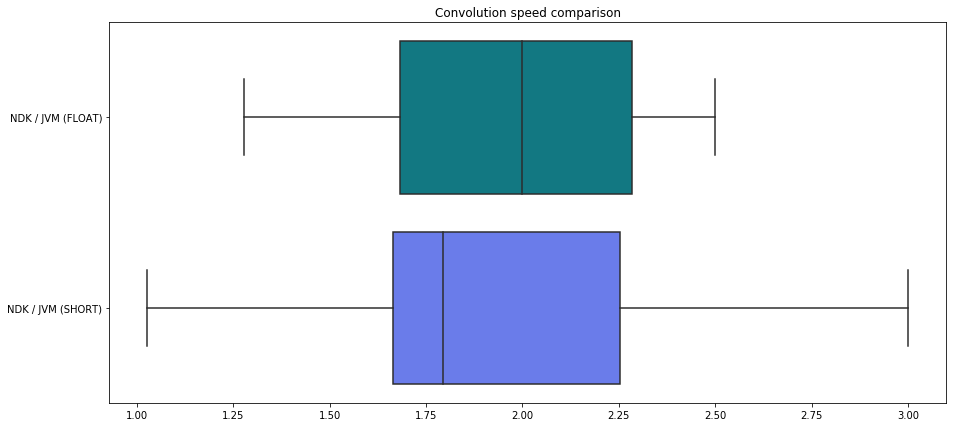

In [8]:
y = ['NDK / JVM (FLOAT)'] * len(floats) + ['NDK / JVM (SHORT)'] * len(shorts)
sns.boxplot(
    x=pd.concat([floats, shorts]),
    y=y
).set_title('Convolution speed comparison')
''

## Summary

On average NDK implementation of convolution was almost 2x faster than JVM implementation on both floats and shorts.

# FFT

JVM version uses [JTransforms](https://github.com/wendykierp/JTransforms) library, which is the most popular pure-java FFT library I could find. It also has an opinion of being quite fast.

NDK version uses [FFTW](http://www.fftw.org/) library which is a de-facto standard for doing FFT in C/C++. It was cross-compiled for Android using [this repository](https://github.com/Lauszus/fftw3-android).

In [9]:
iplot({
    'data': [
        go.Scatter(**dict(
            x = fft.T.index,
            y = fft.T[env],
            mode = 'lines', # markers
            name = env.upper(),
            marker_color = colors[env]
        )) for env in ['jvm_complex', 'jvm_real', 'ndk_complex', 'ndk_real']
    ],
    'layout': go.Layout(title='FFT full benchmark results', xaxis=dict(title='FFT width'), yaxis=dict(title='FFTs / s'))
})

### FFT NDK / JVM speed comparison

In [11]:
complex = fft.T['ndk_complex'] / fft.T['jvm_complex']
real = fft.T['ndk_real'] / fft.T['jvm_real']
y = ['NDK / JVM (COMPLEX)'] * len(complex) + ['NDK / JVM (REAL)'] * len(real)

In [12]:
# complex NDK-to-JVM ratio
complex.describe()

count    20.000000
mean      2.659685
std       1.711970
min       0.369388
25%       1.674781
50%       2.114514
75%       2.914811
max       7.052186
dtype: float64

In [13]:
# real NDK-to-JVM ratio stats
real.describe()

count    20.000000
mean      2.546992
std       1.795768
min       0.492409
25%       1.632118
50%       1.876094
75%       2.452206
max       7.663448
dtype: float64

''

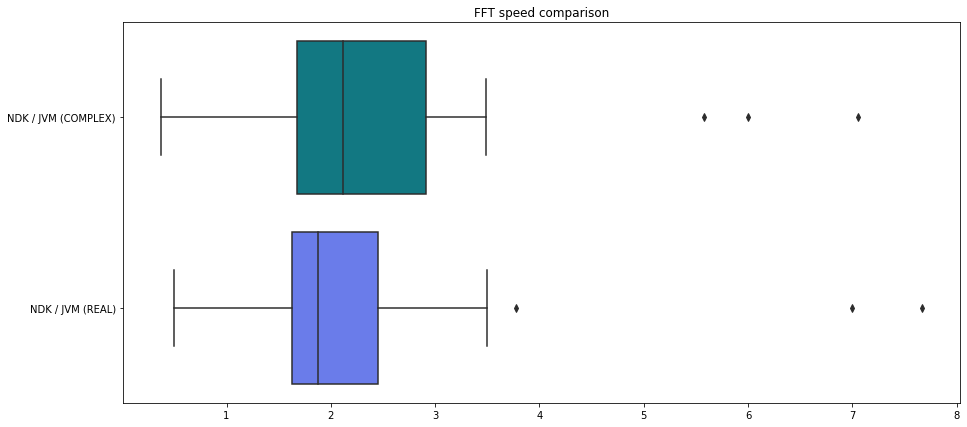

In [14]:
sns.boxplot(
    x=pd.concat([complex, real]),
    y=y
).set_title('FFT speed comparison')
''

## Summary

NDK implementation using complex numbers was on average 2.7 times faster than analogous implementation on JVM. On real numbers NDK implementation is ~2.5 times faster. Long right tail means there's a few outliers where NDK implementation was over 7 times faster.

# Type conversions

The following type conversions were benchmarked:

* short -> float: assuming short value has to be scaled down using a constant representing DAC dynamic range
* float -> short: assuming float value is normalized to <-1, 1> range and has to be scaled up by a constant representing DAC dynamic range
* short -> complex: assuming an array of shorts is in interleaved format where array[k] represent real parts and array[k+1] represent imaginary parts. In C++ std::complex class was used to construct complex objects. In kotlin popular apache math-commons library was used.

In [15]:
conversion_means = conversion.T.mean()

In [16]:
fig = iplot({
    'data': [
        go.Bar(
            x = ['short_float', 'float_short', 'short_complex'],
            y = [conversion_means[series] for series in [f'{env}_short_float', f'{env}_float_short', f'{env}_short_complex']],
            name = env.upper(),
            marker_color = colors[env]
        ) for env in ['jvm', 'ndk']
    ],
    'layout': go.Layout(barmode='group', yaxis=dict(title='conversions / s'))
})

### NDK / JVM speed ratio

In [17]:
short_float = conversion_means['ndk_short_float'] / conversion_means['jvm_short_float']
float_short = conversion_means['ndk_float_short'] / conversion_means['jvm_float_short']
short_complex = conversion_means['ndk_short_complex'] / conversion_means['jvm_short_complex']

short_float, float_short, short_complex

(1.1019002918522331, 1.0506805725267352, 11.540183043774958)

## Summary

NDK implementation of short to float and float to short conversion was only slightly faster than JVM implementation. Short to complex NDK implementation was 11 times faster than JVM implementation which should be attributed to differences between library design in both environments.

# Gotchas

Benchmarking C++ and JVM code is tricky. Here's a few gotchas we found:

* JVM needs warm-up. The first run is often slower than the following runs.
* for loops in both environments can be removed alltogether by compiler (JIT in case of JVM) if the variables modified inside the loop are not visible outside or the value can be calculated during compile-time.